In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from scipy import ndimage
import seaborn as sns
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier

In [2]:
X_train, X_test, y_train, y_test = pickle.load(open('data', 'rb'))

# The problem we are trying to solve is to get maximal income on conversions. For this I want to predict as many partners that may be a good fit and get a rank according to the sum of postback. 

# Since for some 0 in the target variable we don't know the real value, we don't take real 0 in the account. We are interested in predicting rejection and conversion for each redirect, and they are equally important. So I designed a custom score s.t. we prioritize a balance between rejection and convergence precision, but without true 0.

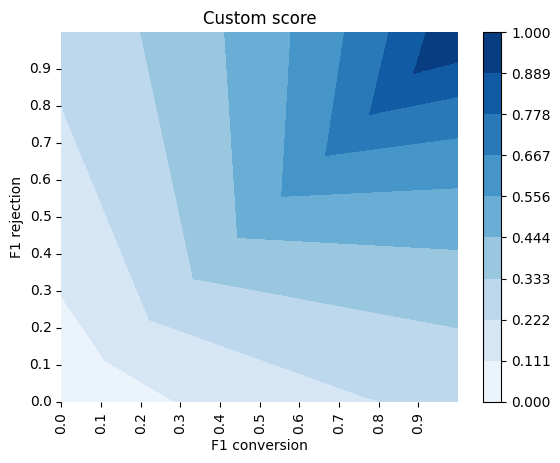

In [3]:
def custom_score(x1, x2, alpha):
    return (x1+x2)/(np.abs(x1-x2)+alpha)


def custom_score_norm(x1, x2, alpha=1):
    return custom_score(x1, x2, alpha)/custom_score(1, 1, alpha)

N = 100
x = np.linspace(0, 1, N)
mat_fun = np.empty((N,N))

for i in range(N):
    for j in range(N):
        mat_fun[N-i-1, j] = custom_score_norm(x[i], x[j])


fig, ax = plt.subplots()
smooth_scale = 5
z = ndimage.zoom(mat_fun, smooth_scale)

cntr = ax.contourf(np.linspace(0, N, N * smooth_scale),
                   np.linspace(0, N, N * smooth_scale),
                   z, levels=np.linspace(0, np.max(mat_fun), 10), cmap='Blues')
ax = sns.heatmap(mat_fun, alpha=0, cbar=False, ax=ax)

ax.set(xlabel="F1 conversion", ylabel="F1 rejection")
ax.set_yticks(range(N, 0, -10), np.round(np.arange(0, 1, 0.1), 1))
ax.set_xticks(range(0, N, 10), np.round(np.arange(0, 1, 0.1), 1))
plt.colorbar(cntr, ax=ax)
plt.title('Custom score')
plt.savefig('custom_score')
plt.show()

In [4]:
def get_metric(y_pred, y_test, ret_C=False):
    C = confusion_matrix(y_test.flatten(), y_pred.flatten(), labels=[-1, 0, 1])
    c_r = C[0, 0]/(C[0,0]+C[2,0]) #predicted rejects - truly rejects
    c_c = C[2,2]/(C[0,2]+C[2,2]) #predicted coonvergence - truly coonvergence
    print(f'rejection precision: {int(c_r*100)}, conversion precision: {int(c_c*100)}')
    return C, custom_score_norm(c_r, c_c)

In [5]:
def get_metric(y_pred, y_test, ret_C=False):
    C = confusion_matrix(y_test.flatten(), y_pred.flatten(), labels=[-1, 0, 1])
    r_p = C[0, 0]/(C[0,0]+C[2,0]) #rejects precision
    c_p = C[2,2]/(C[0,2]+C[2,2]) #convergence precision

    r_r = C[0, 0]/(C[0,0]+C[0,2]) #rejects precision
    c_r = C[2,2]/(C[2,0]+C[2,2]) #convergence precision

    f1_r = 2*(r_p*r_r)/(r_p+r_r) # f1 reject
    f1_c = 2*(c_p*c_r)/(c_p+c_r) # f1 convergence

    score = custom_score_norm(f1_r, f1_c)

    print(f'rejection precision: {int(r_p*100)}, conversion precision: {int(c_p*100)}')
    print(f'rejection recall: {int(r_r*100)}, conversion recall: {int(c_r*100)}')
    if ret_C:
        return C, score
    return score

# Find best parameters of KNN using grid search CV

In [6]:
knn_search_dict = {'n_neighbors': [3, 5, 8],
                  'p': [1, 2],
                  'weights': ['uniform', 'distance']}

knn = KNeighborsClassifier(n_jobs=-1)
score = make_scorer(get_metric, greater_is_better=True)
knn_search = GridSearchCV(estimator = knn, param_grid=knn_search_dict, 
                               cv=3, verbose=3, scoring=score)

knn_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
rejection precision: 87, conversion precision: 19
rejection recall: 81, conversion recall: 26
[CV 1/3] END n_neighbors=3, p=1, weights=uniform;, score=0.329 total time= 2.6min
rejection precision: 87, conversion precision: 22
rejection recall: 83, conversion recall: 28
[CV 2/3] END n_neighbors=3, p=1, weights=uniform;, score=0.344 total time= 2.1min
rejection precision: 88, conversion precision: 22
rejection recall: 84, conversion recall: 30
[CV 3/3] END n_neighbors=3, p=1, weights=uniform;, score=0.351 total time= 2.3min
rejection precision: 85, conversion precision: 21
rejection recall: 82, conversion recall: 26
[CV 1/3] END n_neighbors=3, p=1, weights=distance;, score=0.337 total time= 2.1min
rejection precision: 86, conversion precision: 25
rejection recall: 84, conversion recall: 28
[CV 2/3] END n_neighbors=3, p=1, weights=distance;, score=0.354 total time= 2.1min
rejection precision: 87, conversion precision: 25
rejecti

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': [3, 5, 8], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(get_metric), verbose=3)

In [7]:
print(knn_search.best_params_)

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [9]:
knn_search_dict = {'n_neighbors': [2, 3, 4]}

knn = KNeighborsClassifier(n_jobs=-1, p=1, weights='distance')
knn_search = GridSearchCV(estimator = knn, param_grid=knn_search_dict, 
                               cv=3, verbose=3, scoring=score)

knn_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
rejection precision: 84, conversion precision: 24
rejection recall: 82, conversion recall: 27
[CV 1/3] END .....................n_neighbors=2;, score=0.347 total time= 2.1min
rejection precision: 85, conversion precision: 27
rejection recall: 84, conversion recall: 28
[CV 2/3] END .....................n_neighbors=2;, score=0.360 total time= 2.2min
rejection precision: 86, conversion precision: 29
rejection recall: 85, conversion recall: 31
[CV 3/3] END .....................n_neighbors=2;, score=0.373 total time= 2.1min
rejection precision: 85, conversion precision: 21
rejection recall: 82, conversion recall: 26
[CV 1/3] END .....................n_neighbors=3;, score=0.337 total time= 2.1min
rejection precision: 86, conversion precision: 25
rejection recall: 84, conversion recall: 28
[CV 2/3] END .....................n_neighbors=3;, score=0.354 total time= 2.1min
rejection precision: 87, conversion precision: 25
rejection recall

GridSearchCV(cv=3,
             estimator=KNeighborsClassifier(n_jobs=-1, p=1, weights='distance'),
             param_grid={'n_neighbors': [2, 3, 4]},
             scoring=make_scorer(get_metric), verbose=3)

In [10]:
print(knn_search.best_params_)

{'n_neighbors': 2}


In [11]:
knn_final = KNeighborsClassifier(n_jobs=-1, p=2, weights='distance', n_neighbors=2)
knn_final.fit(X_train, y_train)
y_pred = knn_final.predict(X_test)

C, score = get_metric(y_pred, y_test, True)
print(C, score)

rejection precision: 86, conversion precision: 34
rejection recall: 87, conversion recall: 33
[[201441 137151  29867]
 [106022 866057  16304]
 [ 31530  21238  15823]] 0.39534307784382694


In [12]:
(y_pred==1).any(1).sum()/len(y_pred)

0.4461830194754857

In [13]:
gain_perc = 0.44*0.34
gain_perc

0.1496

# only 44% samples got at least one prediction. If we assume it is 34% correct, we get postback from 14% of leads. Then we need to calculate the rank according to the postback sum.
# I wouldn't consider sending this model to produciton, since we'd rather have rank for each partner instead of classification. I would continue with learning more about ranking and build more suitable solutioon.